In [1]:
# 导入需要使用的包
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

<ipython-input-1-4196427013a1>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import Series, datetime


# 1 数据预处理

## 1.1 文本数据

##  1.1.1 数据清洗

In [ ]:
df_text = pd.read_csv('sentence_emotion_analyse/combined_stock_data.csv',parse_dates=['Date'])

In [ ]:
df_text = df_text[list(df_text.columns[:28])]

In [ ]:
df_text['Headlines'] = np.nan
for i in range(len(df_text)):
    df_text['Headlines'][i]=' '.join(str(x) for x in df_text.iloc[i,2:])

In [ ]:
df_text = df_text[['Date','Label','Headlines']]
df_text.head()[:2]

替换缩写 简写

In [ ]:
import re
def find_abbr(text):
    abbr = []
    for i in re.finditer(r"([A-Za-z]+| )([A-Za-z]\.){2,}", text):
        abbr.append(i.group())
    df_abbr = pd.Series(abbr)
    return df_abbr.unique()

In [ ]:
news_comb = ' '.join(df_text.Headlines)
abbr = find_abbr(news_comb)

In [ ]:
abbr

In [ ]:
for i in range(len(df_text)):
    text = str(df_text.Headlines[i])
    text = re.sub(r"A.T.M.", " Automated Teller Machine ", text)
    text = re.sub(r"C.I.A.", " Central Intelligence Agency ", text)
    text = re.sub(r"D.C.", " District of columbia ", text)
    text = re.sub(r"E.U.", " Europian Union ", text)
    text = re.sub(r"F.B.I.", " Federal Bureau of Investigation ", text)
    text = re.sub(r"H.I.V.", " Human immunodeficiency virus ", text)
    text = re.sub(r"I.H.T.", " inheritance tax ", text)
    text = re.sub(r"I.M.F.", " International Monetary Fund ", text)
    text = re.sub(r"I.D.", " identification ", text)
    text = re.sub(r"L.G.B.T.", " minority ", text)
    text = re.sub(r"M.A.", " Massachusetts ", text)
    text = re.sub(r"N.J.", " new jersey ", text)
    text = re.sub(r"N.K.", " north korea ", text)
    text = re.sub(r"N.S.A.", " National Security Agency ", text)
    text = re.sub(r"N.Y.", " new york ", text)
    text = re.sub(r"P.E.I.", " Prince Edward Island ", text)
    text = re.sub(r"P.M.", " prime minister ", text)
    text = re.sub(r"P.R.C", " china ", text)
    text = re.sub(r"S.A.", " south africa ", text)
    text = re.sub(r"R.I.", " Rhode Island ", text)
    text = re.sub(r"U.A.E.", " United Arab Emirates ", text)
    text = re.sub(r"U.K.", " england ", text)
    text = re.sub(r"U.N.", " New Jersey ", text)
    text = re.sub(r"U.S.", " America ", text)
    text = re.sub(r"U.S.C.", " University of south california ", text)
    text = re.sub(r"W.H.O", " world health organization ", text)
    text = re.sub(r"a.m.", " morning ", text)
    text = re.sub(r"p.m.", " afternoon ", text)
    text = re.sub(r"Ph.D.", " doctor of philosophy ", text)
    text = re.sub(r"sq.m.", " square meter ", text)
    text = re.sub(r"sq.m.", " square meter ", text)

    df_text.Headlines[i] = text

In [ ]:
news_comb = ' '.join(df_text.Headlines)
abbr = find_abbr(news_comb)

In [ ]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [ ]:
ps = PorterStemmer()
wl = WordNetLemmatizer()
corpus = []

删除非字母字符和单字母单词，包括数字和标点符号   
删除停用词

In [ ]:
df_text['headlines_str'] = np.nan
for i in range(len(df_text.Headlines)):
    df_text.headlines_str[i] = df_text.Headlines[i].lower()
    df_text.headlines_str[i] = re.sub("[^a-zA-z]"," ",df_text.headlines_str[i])
    words = nltk.word_tokenize(df_text.headlines_str[i])
    words = [wl.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    df_text.headlines_str[i]=' '.join(words)

## 1.1.2 embedding

In [ ]:
df_text['headlines_words'] = [df_text.headlines_str[i].split() for i in range(len(df_text))]

In [ ]:
df_text.head()

In [ ]:
from gensim.models import Word2Vec
import gensim

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(r'E:/File/coding/MLDL_learning/dataset/english-embedding/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
def doc2vec(model, wordlist):
    vector_list = [model[word] for word in wordlist if word in model]
    doc_vector = np.mean(vector_list, axis=0)
    return doc_vector

In [ ]:
df_text['word2vec'] = [doc2vec(model, doc) for doc in df_text.headlines_words]  

In [ ]:
df_text.head()

In [ ]:
# 保存起来 下次直接读取就可以，不必每次都跑
df_text.to_pickle("./preprocessed_df.pkl")

直接读取保存的中间数据就可以

In [2]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df = pd.read_pickle(r'preprocessed_df.pkl')

In [4]:
# 不需要标题了，因为已经汇总
df = df.drop('Headlines',axis=1)

In [5]:
# 数据类型
print(df.shape)
print(df.dtypes)

(1989, 5)
Date               datetime64[ns]
Label                       int64
headlines_str              object
headlines_words            object
word2vec                   object
dtype: object


##  1.2 股票数据

In [6]:
# 价格序列
stock_prices = "sentence_emotion_analyse/stocknews/DJIA_table.csv"
stock_data = pd.read_csv(stock_prices, parse_dates=[0])
stock_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [7]:
# 数据类型
print(stock_data.shape)
print(stock_data.dtypes)

(1989, 7)
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object


## 1.3 合并数据

In [8]:
# 合并标题和股票价格
merged_dataframe = df.merge(stock_data, how='inner', on='Date', left_index=True)
print(merged_dataframe.shape)
merged_dataframe.head()

(1989, 11)


,Date,Label,headlines_str,headlines_words,word2vec,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,b georgia down two russian warplane country mo...,"[b, georgia, down, two, russian, warplane, cou...","[-0.030426025, 0.042169377, 0.043114804, 0.110...",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,b wont america nato help u wont help u help ir...,"[b, wont, america, nato, help, u, wont, help, ...","[-0.04963903, 0.029282805, 0.061783727, 0.1101...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,b remember adorable year old sang opening cere...,"[b, remember, adorable, year, old, sang, openi...","[-0.017341351, 0.051923424, 0.051041078, 0.108...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,0,b america refuse israel weapon attack iran rep...,"[b, america, refuse, israel, weapon, attack, i...","[-0.025739402, 0.040334575, 0.071311414, 0.098...",11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,1,b expert morning legalise drug b war south ose...,"[b, expert, morning, legalise, drug, b, war, s...","[-0.020019358, 0.043589104, 0.06413258, 0.1148...",11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [9]:
sentiment = pd.read_csv('sentence_emotion_analyse/combined_stock_data.csv',parse_dates=['Date'])
sentiment = sentiment[list(sentiment.columns[28:]) + ['Date']]
merged_dataframe = merged_dataframe.merge(sentiment, how='inner', on='Date', left_index=True)
print(merged_dataframe.shape)
merged_dataframe.head()

(1989, 17)


,Date,Label,headlines_str,headlines_words,word2vec,Open,High,Low,Close,Volume,Adj Close,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,2008-08-08,0,b georgia down two russian warplane country mo...,"[b, georgia, down, two, russian, warplane, cou...","[-0.030426025, 0.042169377, 0.043114804, 0.110...",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou...",85.714286,14.285714,21.428571,14.285714,64.285714
1,2008-08-11,1,b wont america nato help u wont help u help ir...,"[b, wont, america, nato, help, u, wont, help, ...","[-0.04963903, 0.029282805, 0.061783727, 0.1101...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...,77.777778,22.222222,33.333333,22.222222,44.444444
2,2008-08-12,0,b remember adorable year old sang opening cere...,"[b, remember, adorable, year, old, sang, openi...","[-0.017341351, 0.051923424, 0.051041078, 0.108...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...,53.333333,46.666667,20.000000,46.666667,33.333333
3,2008-08-13,0,b america refuse israel weapon attack iran rep...,"[b, america, refuse, israel, weapon, attack, i...","[-0.025739402, 0.040334575, 0.071311414, 0.098...",11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,40.000000,60.000000,20.000000,60.000000,20.000000
4,2008-08-14,1,b expert morning legalise drug b war south ose...,"[b, expert, morning, legalise, drug, b, war, s...","[-0.020019358, 0.043589104, 0.06413258, 0.1148...",11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909


In [10]:
# 把label放在最后一列
cols = list(merged_dataframe)
print(cols)
cols.append(cols.pop(cols.index('Label')))
merged_dataframe = merged_dataframe.loc[:, cols]
merged_dataframe.head()

['Date', 'Label', 'headlines_str', 'headlines_words', 'word2vec', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Para', 'Subjectivity', 'Objectivity', 'Positive', 'Neutral', 'Negative']


,Date,headlines_str,headlines_words,word2vec,Open,High,Low,Close,Volume,Adj Close,Para,Subjectivity,Objectivity,Positive,Neutral,Negative,Label
0,2008-08-08,b georgia down two russian warplane country mo...,"[b, georgia, down, two, russian, warplane, cou...","[-0.030426025, 0.042169377, 0.043114804, 0.110...",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou...",85.714286,14.285714,21.428571,14.285714,64.285714,0
1,2008-08-11,b wont america nato help u wont help u help ir...,"[b, wont, america, nato, help, u, wont, help, ...","[-0.04963903, 0.029282805, 0.061783727, 0.1101...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...,77.777778,22.222222,33.333333,22.222222,44.444444,1
2,2008-08-12,b remember adorable year old sang opening cere...,"[b, remember, adorable, year, old, sang, openi...","[-0.017341351, 0.051923424, 0.051041078, 0.108...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...,53.333333,46.666667,20.000000,46.666667,33.333333,0
3,2008-08-13,b america refuse israel weapon attack iran rep...,"[b, america, refuse, israel, weapon, attack, i...","[-0.025739402, 0.040334575, 0.071311414, 0.098...",11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,40.000000,60.000000,20.000000,60.000000,20.000000,0
4,2008-08-14,b expert morning legalise drug b war south ose...,"[b, expert, morning, legalise, drug, b, war, s...","[-0.020019358, 0.043589104, 0.06413258, 0.1148...",11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909,1


In [11]:
# 把Volume的数据类型改成float
#merged_dataframe['Date'] = pd.to_datetime(merged_dataframe['Date'])
merged_dataframe['Volume'] = merged_dataframe['Volume'].astype(float)
print(cols)
merged_dataframe.index = merged_dataframe.index.sort_values()
merged_dataframe.head()

['Date', 'headlines_str', 'headlines_words', 'word2vec', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Para', 'Subjectivity', 'Objectivity', 'Positive', 'Neutral', 'Negative', 'Label']


,Date,headlines_str,headlines_words,word2vec,Open,High,Low,Close,Volume,Adj Close,Para,Subjectivity,Objectivity,Positive,Neutral,Negative,Label
0,2008-08-08,b georgia down two russian warplane country mo...,"[b, georgia, down, two, russian, warplane, cou...","[-0.030426025, 0.042169377, 0.043114804, 0.110...",11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou...",85.714286,14.285714,21.428571,14.285714,64.285714,0
1,2008-08-11,b wont america nato help u wont help u help ir...,"[b, wont, america, nato, help, u, wont, help, ...","[-0.04963903, 0.029282805, 0.061783727, 0.1101...",11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,b'Why wont America and Nato help us? If they w...,77.777778,22.222222,33.333333,22.222222,44.444444,1
2,2008-08-12,b remember adorable year old sang opening cere...,"[b, remember, adorable, year, old, sang, openi...","[-0.017341351, 0.051923424, 0.051041078, 0.108...",11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,b'Remember that adorable 9-year-old who sang a...,53.333333,46.666667,20.000000,46.666667,33.333333,0
3,2008-08-13,b america refuse israel weapon attack iran rep...,"[b, america, refuse, israel, weapon, attack, i...","[-0.025739402, 0.040334575, 0.071311414, 0.098...",11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,40.000000,60.000000,20.000000,60.000000,20.000000,0
4,2008-08-14,b expert morning legalise drug b war south ose...,"[b, expert, morning, legalise, drug, b, war, s...","[-0.020019358, 0.043589104, 0.06413258, 0.1148...",11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909,1


# 2 数据质量检查

In [12]:
print(merged_dataframe.describe())

               Open          High           Low         Close        Volume  \
count   1989.000000   1989.000000   1989.000000   1989.000000  1.989000e+03   
mean   13459.116048  13541.303173  13372.931728  13463.032255  1.628110e+08   
std     3143.281634   3136.271725   3150.420934   3144.006996  9.392343e+07   
min     6547.009766   6709.609863   6469.950195   6547.049805  8.410000e+06   
25%    10907.339844  11000.980469  10824.759766  10913.379883  1.000000e+08   
50%    13022.049805  13088.110352  12953.129883  13025.580078  1.351700e+08   
75%    16477.699219  16550.070312  16392.769531  16478.410156  1.926000e+08   
max    18315.060547  18351.359375  18272.560547  18312.390625  6.749200e+08   

          Adj Close  Subjectivity  Objectivity     Positive      Neutral  \
count   1989.000000   1986.000000  1986.000000  1986.000000  1986.000000   
mean   13463.032255     59.430746    40.569254    20.392350    40.569254   
std     3144.006996     22.331549    22.331549    17.829805 

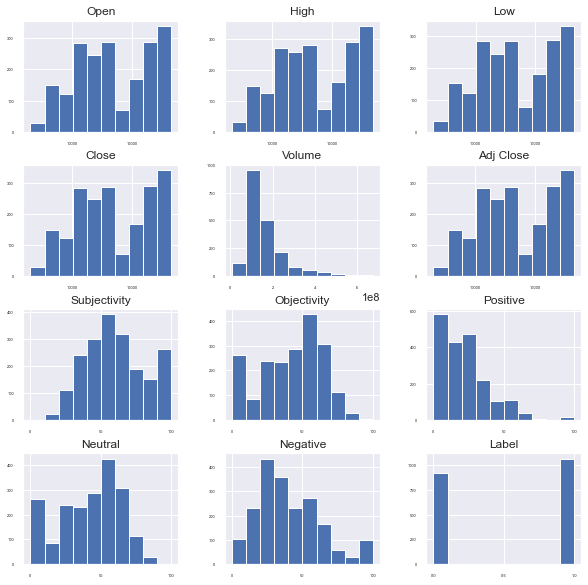

In [13]:
# 直方图
sns.set()
merged_dataframe.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

很多特征虽然不是正态分布，但是分布相对比较均匀。

标签的分布也比较均匀。

In [14]:
# 设置显示字体等，中文表示
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [15]:
merged_dataframe.columns

Index(['Date', 'headlines_str', 'headlines_words', 'word2vec', 'Open', 'High',
       'Low', 'Close', 'Volume', 'Adj Close', 'Para', 'Subjectivity',
       'Objectivity', 'Positive', 'Neutral', 'Negative', 'Label'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

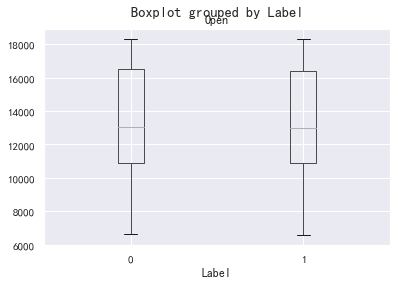

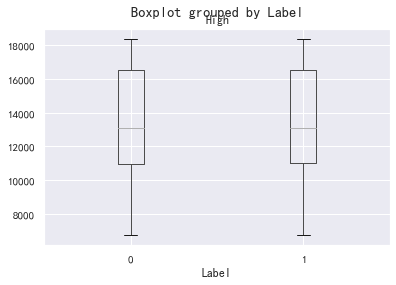

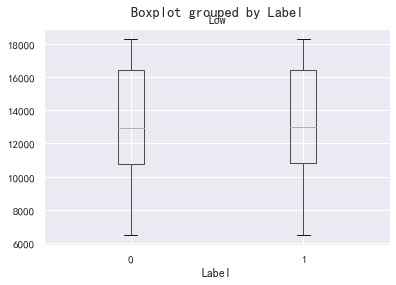

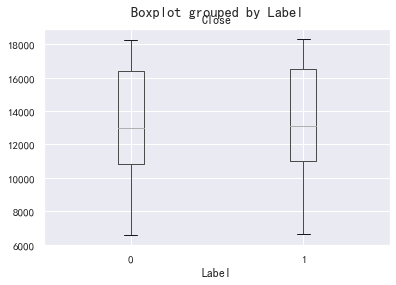

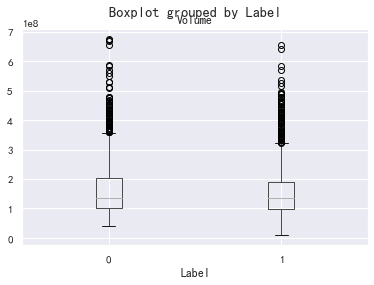

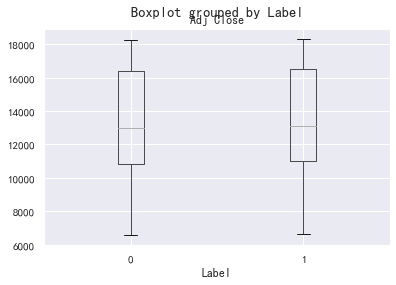

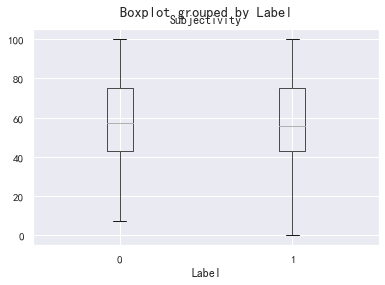

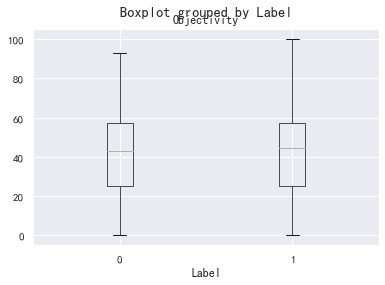

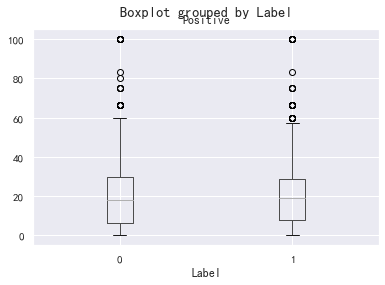

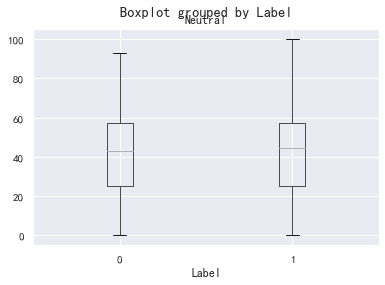

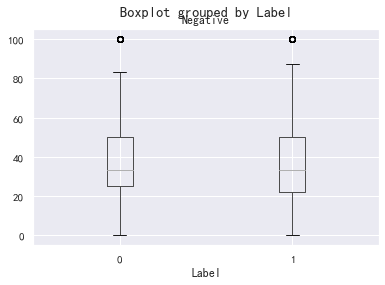

In [16]:
# 箱型图
fig = plt.figure()
#Variable
for col in ['Open', 'High','Low', 'Close', 'Volume', 'Adj Close','Subjectivity',\
       'Objectivity', 'Positive', 'Neutral', 'Negative']:
    if col != 'Date' and col != 'Label':
        merged_dataframe.boxplot(column=[col], by="Label")
        plt.show()

In [17]:
print("Size")
print(merged_dataframe.groupby('Label').size())

Size
Label
0     924
1    1065
dtype: int64


In [18]:
bin_col = merged_dataframe.columns

zero_list = []
one_list = []
for col in bin_col:
    zero_count = 0
    one_count = 0
    for ix, val in merged_dataframe[col].iteritems():
        if merged_dataframe.loc[ix, 'Label'] == 0:
            zero_count += 1
        else:
            one_count += 1
    zero_list.append(zero_count)
    one_list.append(one_count)

    
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='0计数'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='1计数'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='label 中 1 和 0 的计数'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

以label去区分，每一属性的数量都是差不多的

<AxesSubplot:>

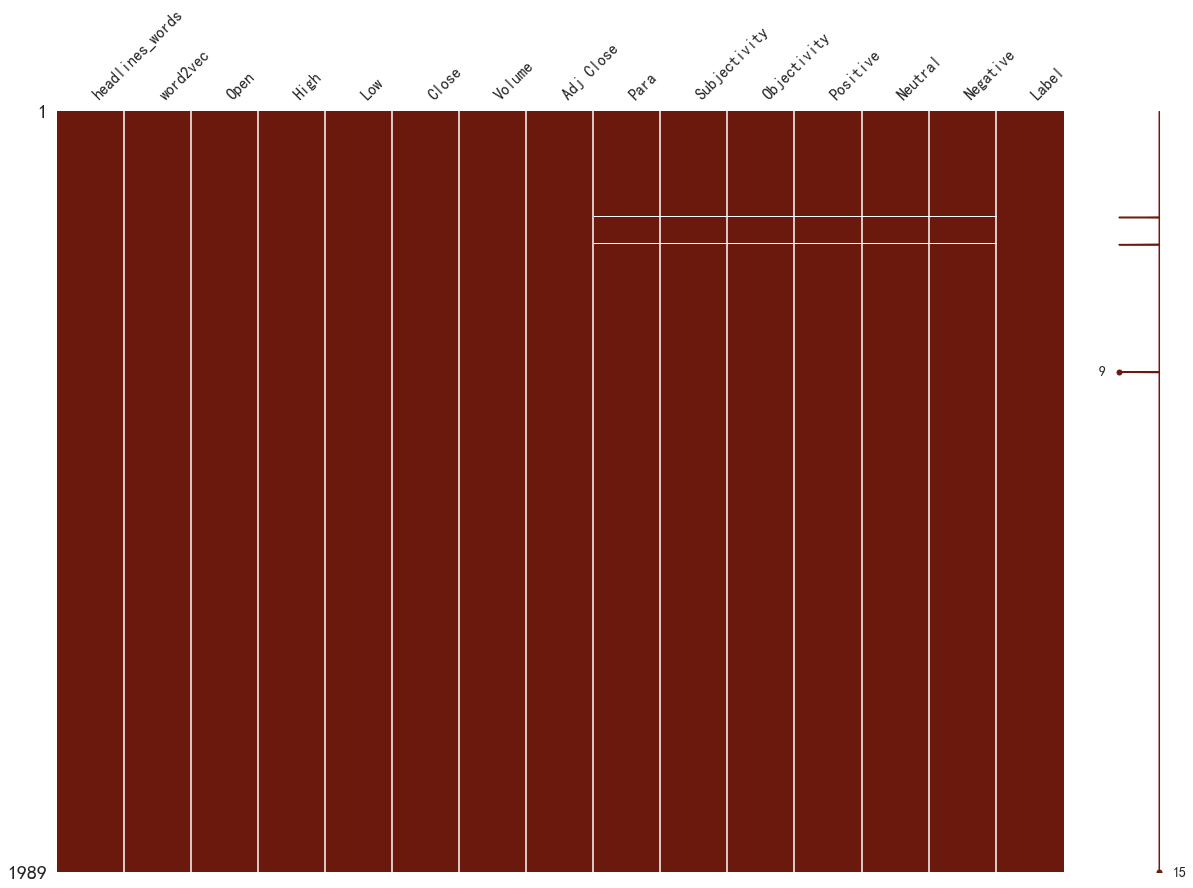

In [19]:
md_copy = merged_dataframe
md_copy = md_copy.replace(-1, np.NaN)#把-1换成nan
import missingno as msno
# 空值
msno.matrix(df=md_copy.iloc[:,2:], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [20]:
# 把 NaN 值更改为该列的平均值 
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    merged_dataframe[col] = merged_dataframe[col].fillna(merged_dataframe[col].mean())

# 最大的不同：以今天预测明天（改变LABEL）

In [21]:
# 把label挪动1格（以今天预测明天）
labels = merged_dataframe.Label[:]
merged_dataframe = merged_dataframe[:-1]
merged_dataframe.Label = labels

E:\download\anaconda\download\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 3 特征编码方式

In [22]:
merged_dataframe.columns

Index(['Date', 'headlines_str', 'headlines_words', 'word2vec', 'Open', 'High',
       'Low', 'Close', 'Volume', 'Adj Close', 'Para', 'Subjectivity',
       'Objectivity', 'Positive', 'Neutral', 'Negative', 'Label'],
      dtype='object')

In [23]:
X = merged_dataframe.loc[:,'headlines_str':'Negative']
y = merged_dataframe.loc[:,'Label']

# 70% 训练集  30% 测试集
train_size = int(len(X.index) * 0.7)

X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]

print('总数: %d' % (len(X.index)))
print('X 训练数目: %d' % (len(X_train.index)))
print('X 测试数目: %d' % (len(X_test.index)))
print('y 训练数目: %d' % (len(y_train)))
print('y 测试数目: %d' % (len(y_test)))

总数: 1988
X 训练数目: 1392
X 测试数目: 597
y 训练数目: 1392
y 测试数目: 597


## 3.1 词袋模型

In [24]:
count_vect = CountVectorizer(analyzer='word')
X_bag = count_vect.fit_transform(X_train.headlines_str).toarray()

In [25]:
X_bag.shape

(1392, 25042)

In [26]:
col = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
for c in col:
    X_bag = np.insert(X_bag, 0, values=X_train[c], axis=1)

In [27]:
X_bag.shape

(1392, 25048)

## 3.2 TF-IDF

In [28]:
tfidf_vect = TfidfVectorizer(analyzer='word')
X_TFIDF = tfidf_vect.fit_transform(X_train.headlines_str).toarray()

In [29]:
X_TFIDF.shape

(1392, 25042)

In [30]:
for c in col:
    X_TFIDF = np.insert(X_TFIDF, 0, values=X_train[c], axis=1)

In [31]:
X_TFIDF.shape

(1392, 25048)

## 3.3 W2V

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [33]:
X_w2v = scaler.fit_transform(np.array(list(X_train.word2vec)))

## 3.4 情感分析

In [34]:
X_train.columns

Index(['headlines_str', 'headlines_words', 'word2vec', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close', 'Para', 'Subjectivity', 'Objectivity',
       'Positive', 'Neutral', 'Negative'],
      dtype='object')

In [35]:
X_senti = X_train[['Open', 'High', 'Low',\
       'Close', 'Volume', 'Adj Close',\
        'Subjectivity', 'Objectivity',\
       'Positive', 'Neutral', 'Negative']]

# 4 特征筛选与模型求解

## 4.1 BASELINE与模型选择

In [36]:
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [37]:
int(len(X_train)*0.9)

1252

In [38]:
def baseline_model_filter(modellist, X, y):
    split_num = int(len(X_train)*0.9)
    X_tr, X_va, y_tr, y_va = X[:split_num],X[split_num:],y[:split_num],y[split_num:]
    for modelname,model in modellist:
        model.fit(X_tr, y_tr) 
        print(f'{modelname} \n report:{classification_report(y_va, model.predict(X_va))}')

### 4.1.1 词袋

In [39]:
baseline_model_filter(models,X_bag,y_train)

E:\download\anaconda\download\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



LR 
 report:              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.51      1.00      0.67        71

    accuracy                           0.51       140
   macro avg       0.25      0.50      0.34       140
weighted avg       0.26      0.51      0.34       140

LDA 
 report:              precision    recall  f1-score   support

           0       0.39      0.10      0.16        69
           1       0.49      0.85      0.62        71

    accuracy                           0.48       140
   macro avg       0.44      0.47      0.39       140
weighted avg       0.44      0.48      0.39       140

KNN 
 report:              precision    recall  f1-score   support

           0       0.50      0.49      0.50        69
           1       0.51      0.52      0.52        71

    accuracy                           0.51       140
   macro avg       0.51      0.51      0.51       140
weighted avg       0.51      0.51   

E:\download\anaconda\download\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:54:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost 
 report:              precision    recall  f1-score   support

           0       0.47      0.23      0.31        69
           1       0.50      0.75      0.60        71

    accuracy                           0.49       140
   macro avg       0.49      0.49      0.45       140
weighted avg       0.49      0.49      0.46       140



### 4.1.2 TFIDF

In [40]:
baseline_model_filter(models,X_TFIDF,y_train)

E:\download\anaconda\download\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



LR 
 report:              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.51      1.00      0.67        71

    accuracy                           0.51       140
   macro avg       0.25      0.50      0.34       140
weighted avg       0.26      0.51      0.34       140

LDA 
 report:              precision    recall  f1-score   support

           0       0.21      0.04      0.07        69
           1       0.48      0.85      0.61        71

    accuracy                           0.45       140
   macro avg       0.35      0.44      0.34       140
weighted avg       0.35      0.45      0.34       140

KNN 
 report:              precision    recall  f1-score   support

           0       0.50      0.49      0.50        69
           1       0.51      0.52      0.52        71

    accuracy                           0.51       140
   macro avg       0.51      0.51      0.51       140
weighted avg       0.51      0.51   

E:\download\anaconda\download\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:57:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost 
 report:              precision    recall  f1-score   support

           0       0.45      0.39      0.42        69
           1       0.47      0.54      0.50        71

    accuracy                           0.46       140
   macro avg       0.46      0.46      0.46       140
weighted avg       0.46      0.46      0.46       140



### 4.1.3 W2V

In [41]:
baseline_model_filter(models,X_w2v,y_train)

E:\download\anaconda\download\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LR 
 report:              precision    recall  f1-score   support

           0       0.55      0.45      0.50        69
           1       0.55      0.65      0.59        71

    accuracy                           0.55       140
   macro avg       0.55      0.55      0.54       140
weighted avg       0.55      0.55      0.55       140

LDA 
 report:              precision    recall  f1-score   support

           0       0.57      0.48      0.52        69
           1       0.56      0.65      0.60        71

    accuracy                           0.56       140
   macro avg       0.56      0.56      0.56       140
weighted avg       0.56      0.56      0.56       140

KNN 
 report:              precision    recall  f1-score   support

           0       0.55      0.42      0.48        69
           1       0.54      0.66      0.59        71

    accuracy                           0.54       140
   macro avg       0.54      0.54      0.54       140
weighted avg       0.54      0.54   

E:\download\anaconda\download\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBoost 
 report:              precision    recall  f1-score   support

           0       0.51      0.39      0.44        69
           1       0.52      0.63      0.57        71

    accuracy                           0.51       140
   macro avg       0.51      0.51      0.51       140
weighted avg       0.51      0.51      0.51       140



### 4.1.4 情感分析

In [42]:
baseline_model_filter(models,X_senti,y_train)

LR 
 report:              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.51      1.00      0.67        71

    accuracy                           0.51       140
   macro avg       0.25      0.50      0.34       140
weighted avg       0.26      0.51      0.34       140

LDA 
 report:              precision    recall  f1-score   support

           0       1.00      0.83      0.90        69
           1       0.86      1.00      0.92        71

    accuracy                           0.91       140
   macro avg       0.93      0.91      0.91       140
weighted avg       0.93      0.91      0.91       140

KNN 
 report:              precision    recall  f1-score   support

           0       0.50      0.49      0.50        69
           1       0.51      0.52      0.52        71

    accuracy                           0.51       140
   macro avg       0.51      0.51      0.51       140
weighted avg       0.51      0.51   

E:\download\anaconda\download\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




CART 
 report:              precision    recall  f1-score   support

           0       0.59      0.58      0.58        69
           1       0.60      0.61      0.60        71

    accuracy                           0.59       140
   macro avg       0.59      0.59      0.59       140
weighted avg       0.59      0.59      0.59       140

NB 
 report:              precision    recall  f1-score   support

           0       1.00      0.01      0.03        69
           1       0.51      1.00      0.68        71

    accuracy                           0.51       140
   macro avg       0.76      0.51      0.35       140
weighted avg       0.75      0.51      0.36       140

SVM 
 report:              precision    recall  f1-score   support

           0       0.50      0.01      0.03        69
           1       0.51      0.99      0.67        71

    accuracy                           0.51       140
   macro avg       0.50      0.50      0.35       140
weighted avg       0.50      0.51 

E:\download\anaconda\download\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBoost 
 report:              precision    recall  f1-score   support

           0       0.54      0.46      0.50        69
           1       0.54      0.62      0.58        71

    accuracy                           0.54       140
   macro avg       0.54      0.54      0.54       140
weighted avg       0.54      0.54      0.54       140

